In [40]:
import math
import numpy as np 
import pandas as pd 
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import seaborn as sns

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.densenet import DenseNet201

import tensorflow as tf
from keras import Model

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm_notebook as tqdm

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler

import random
import cv2

In [41]:
train_img_dir = '../input/airbus-ship-detection/train_v2/'
train_seg_csv = '../input/airbus-ship-detection/train_ship_segmentations_v2.csv'
test_img_dir = '../input/airbus-ship-detection/test_v2'
traincsv = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [42]:
traincsv.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [43]:
c=[]
for i in (traincsv["EncodedPixels"].notnull()):

    if i==True:
        c.append(1)
    else:
        c.append(0)
        
traincsv["class"]=c

traincsv_unique = traincsv.drop_duplicates(subset=['ImageId'], keep='first')

print(traincsv_unique.head())
print("\n Shape of the Dataframe:",traincsv_unique.shape)

         ImageId                                      EncodedPixels  class
0  00003e153.jpg                                                NaN      0
1  0001124c7.jpg                                                NaN      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
8  0001b1832.jpg                                                NaN      0

 Shape of the Dataframe: (192556, 3)


In [44]:
traincsv_unique = traincsv_unique.sort_values(by = ["class"])
traincsv_unique.reset_index(drop = True, inplace = True)

traincsv_unique = pd.concat([traincsv_unique.loc[:4999], traincsv_unique.loc[187556:]])

In [45]:
traincsv_unique["class"].value_counts()

0    5000
1    5000
Name: class, dtype: int64

In [46]:
IMAGE_SIZE = 128
paths = traincsv_unique["ImageId"]

In [47]:
batch_images = np.zeros((len(traincsv_unique["ImageId"]), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)

for i, f in tqdm(enumerate(paths)):
  #print(f)
  img = Image.open(train_img_dir+f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

0it [00:00, ?it/s]

In [48]:
batch_images.shape

(10000, 128, 128, 3)

In [49]:
np.save("E:\\Resume",batch_images)

In [50]:
# batch_images1=batch_images.flatten()
# batch_images1=batch_images.swapaxes(1, 2).reshape(10000*128, 128*3)

# from numpy import savetxt
# savetxt('batch_images.csv', batch_images1, delimiter=',')

In [51]:
y = np.array(traincsv_unique["class"])
print(y)

[0 0 0 ... 1 1 1]


In [52]:
np.save("class",y)

In [53]:
x_train_data , X_val, y_train_data , y_val = train_test_split(batch_images, y, test_size=0.2, random_state=42)

In [54]:
model = DenseNet201(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False, weights='imagenet', classes=2)


for layers in model.layers:
  layers.trainable = False

x=model.layers[-1].output
# x=tf.keras.layers.Dense(1024,activation='relu')(x)  
#x=tf.keras.layers.Dense(512,activation='relu')(x) 
x=tf.keras.layers.Flatten()(x)
# x=tf.keras.layers.Dense(128,activation='tanh')(x)
# x=tf.keras.layers.Dropout(0.4)(x)
x=tf.keras.layers.Dense(64,activation='tanh')(x)
x=tf.keras.layers.Dropout(0.4)(x)
preds=tf.keras.layers.Dense(1,activation='sigmoid')(x) 


model = Model(inputs = model.inputs, outputs = preds)

74850304/74836368 [==============================] - 0s 0us/step


Epoch 1/20
125/125 [==============================] - 26s 122ms/step - loss: 0.3542 - binary_accuracy: 0.8569 - val_loss: 0.2602 - val_binary_accuracy: 0.8910
Epoch 2/20
125/125 [==============================] - 11s 87ms/step - loss: 0.2903 - binary_accuracy: 0.8813 - val_loss: 0.2448 - val_binary_accuracy: 0.9020
Epoch 3/20
125/125 [==============================] - 11s 87ms/step - loss: 0.2553 - binary_accuracy: 0.8967 - val_loss: 0.2366 - val_binary_accuracy: 0.9055
Epoch 4/20
125/125 [==============================] - 11s 87ms/step - loss: 0.2479 - binary_accuracy: 0.9007 - val_loss: 0.2419 - val_binary_accuracy: 0.9040
Epoch 5/20
125/125 [==============================] - 11s 87ms/step - loss: 0.2415 - binary_accuracy: 0.9057 - val_loss: 0.2477 - val_binary_accuracy: 0.9020
Epoch 6/20
125/125 [==============================] - 11s 85ms/step - loss: 0.2440 - binary_accuracy: 0.9046 - val_loss: 0.2347 - val_binary_accuracy: 0.9060
Epoch 7/20
125/125 [==============================]

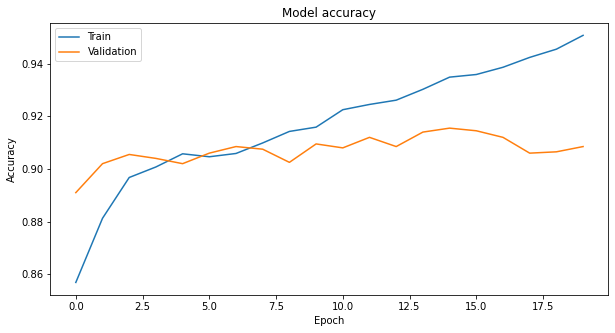

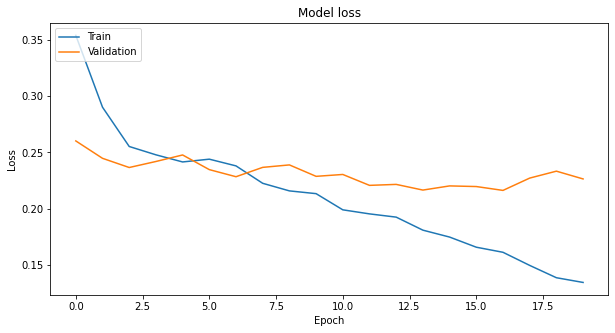

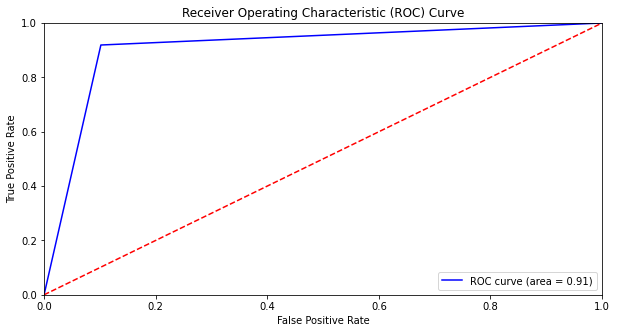

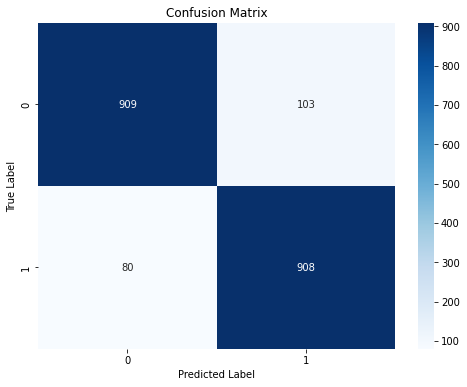

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1012
           1       0.90      0.92      0.91       988

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [55]:
ALPHA = 1.0

def schedule(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

# model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)

# for layers in model.layers:
#     layers.trainable = False

# x = model.layers[-1].output
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.6)(x)
# preds = tf.keras.layers.Dense(1, activation='sigmoid')(x) 

# model = Model(inputs=model.inputs, outputs=preds)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

stop = EarlyStopping(monitor='val_binary_accuracy', patience=5, mode="max")
learning_rate = LearningRateScheduler(schedule)
reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.2, patience=5, min_lr=1e-7, verbose=1, mode="max")

# Fit the model and capture the history
history = model.fit(x_train_data,
                    y_train_data,
                    batch_size=64,
                    epochs=20,
                    callbacks=[stop, reduce_lr, learning_rate],
                    validation_data=(X_val, y_val))

# Plot training & validation accuracy values
def plot_accuracy(history):
    print("Available keys in history.history:", history.history.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot training & validation loss values
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Print classification report
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

# Generating evaluation plots
def evaluate_model(model, X_val, y_val, history):
    predictions = np.round(np.squeeze(model.predict(X_val)))
    
    # Plot accuracy and loss
    plot_accuracy(history)
    plot_loss(history)
    
    # Plot ROC curve
    plot_roc_curve(y_val, predictions)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_val, predictions)
    
    # Print classification report
    print_classification_report(y_val, predictions)

# Call the evaluation function
evaluate_model(model, X_val, y_val, history)

In [56]:
predictions = np.round(np.squeeze(model.predict(X_val)))
predictions

array([1., 1., 0., ..., 1., 0., 1.], dtype=float32)

For 1327th image:
	The actual label class:  1
	The predicted label class:  1


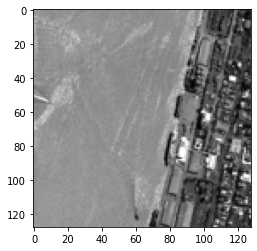

In [57]:
i=random.randint(1,1500)

plt.imshow(X_val[i][:, :, 0],cmap='gray')
print("For {}th image:".format(i))
print("\tThe actual label class: ",y_val[i])
print("\tThe predicted label class: ",int(predictions[i]))

The predicted label 0.0


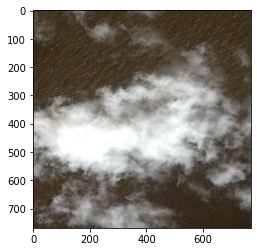

In [58]:
unscaled = cv2.imread("../input/airbus-ship-detection/test_v2/000f7d875.jpg")

image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
print("The predicted label",np.round(np.squeeze(model.predict(x = np.array([feat_scaled])))))
plt.imshow(unscaled)